# Exercise: TKO_3120 Machine Learning and Pattern Recognition

# The problem
CIFAR-10 is a dataset consist of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The test images are composed of 1000 randomly selected images from each class. The training images contains 5,000 images from each class in random order. The goal of this execrisce, is to build an algorithm which takes a random image and classify it to one of the 10 classes with as high as possible accuracy.

# Import Packages
Import all the packages needed for this notebook in one cell

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import os
import platform
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from skimage.feature import local_binary_pattern

# Load the raw CIFAR-10 data

Donwnload the dataset from the zip file (cifar-10-batches-py) in moodle. Then unzip the file. 

In [23]:
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

In [24]:
def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [25]:
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

In [39]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cifar10'
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Print flattering image data
print('Training data shape: ', X_train.shape) # (imgs num, width, height, RGB)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


# Data Visualization

Show a few examples of training images from each class.

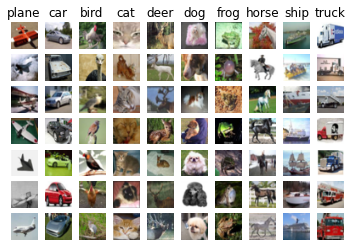

In [6]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# Feature extraction



## 1- Color Mean and Standard Deviation
**Question (1 point):** 
Calculate the below mentioned color features for each image:

- Mean for each RGB color channel
- Standard Deviation (STD) for each RGB color channel


In [7]:
mean = [] 
std = [] 

for sample in range(0,50000):

    # Extract red channel
    r = X_train[sample][:,:,0] # [pic's num][get all rows, all columns, and the 1st color channel]

    # Extract green channel
    g = X_train[sample][:,:,1] # 2nd channel

    # Extract blue channel
    b = X_train[sample][:,:,2] # 3rd channel

    # Count mean and std
    mean_r = np.mean(r)
    std_r = np.std(r)

    mean_g = np.mean(g)
    std_g = np.std(g)

    mean_b = np.mean(b)
    std_b = np.std(b)

    mean.append([mean_r,mean_g,mean_b]) # data of 1 pic
    std.append([std_r,std_g,std_b])

In [8]:
mean = np.asarray(mean)
std = np.asarray(std)
print(mean.shape)
print(std.shape)

(50000, 3)
(50000, 3)


## 2- Color Histograms
**Question (1 point):**

   Obtain histogram feature  (e.g. cv2.calcHist from OpenCV) for each of RGB channel with 8 bins per channel. 

In [9]:
# Each value corresponds to number of pixels in that image with its corresponding pixel value

hist = []
    
for sample in range(0,50000): 

    img = X_train[sample].astype(np.uint8)

    histr_r = cv2.calcHist([img],[0],None,[8],[0,256]) # (images, channels, mask(all image), 
                                                       # histSize(num of bins), ranges)
    histr_g = cv2.calcHist([img],[1],None,[8],[0,256])
    histr_b = cv2.calcHist([img],[2],None,[8],[0,256])

    hist.append([histr_r,histr_g,histr_b]) # data of 1 image

hist = np.asarray(hist)
print(hist.shape)

(50000, 3, 8, 1)


In [43]:
hist = hist.reshape(50000,3,8,1).reshape(50000,3*8*1)
print(hist.shape)

(50000, 24)


## 3- Local Binary Patterns (LBP)
**Question (1 point):**
Create Local Binary Pattern of each image 

    

In [46]:
lbp = []

for sample in range (0,50000):
    img_rgb = X_train[sample].astype(np.float32)
    
    # Converting RGB image into gray one
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY) 
    
    lbp_1 = local_binary_pattern(img_gray, 8, 3, 'default') # (radius, n_points, method)
    
    lbp.append(lbp_1)

In [47]:
lbp = np.asarray(lbp)
print(lbp.shape)
lbp = lbp.reshape(50000,32,32).reshape(50000,32*32)
print(lbp.shape)

(50000, 32, 32)
(50000, 1024)


Gather all features (Mean, STD, HIS and LBP) into an input array X, and the image classes into an output array y. Standardize the
feature values in X. One standard way of doing it is zscore normalization, meaning that the feature values will have zero mean and unit variance.

In [13]:
scaler = StandardScaler()
standard = scaler.fit_transform(np.column_stack([mean, std, hist, lbp])) #center data 

## PCA 
**Question (1 point):** 

Use PCA with 10 component to reduce dimension of the feature vector X.

In [28]:
pca = PCA(n_components=10)

transform = pca.fit_transform(standard) # reduce dimention

X = transform[:50000]
X_test = transform[:10000]
y = y_train

print(X.shape, y.shape, X_test.shape, y_test.shape)

(50000, 10) (50000,) (10000, 10) (10000,)


# Build classifiers and estimate their performance

## 1- K-Nearest Neighbor (K-NN) 

In this exercise you will implement a K-NN classifier and understand the basic Image Classification pipeline and  cross-validation.

**Question (2 points):** 

Perform 5-fold cross validation to find the best value of k in range 1 to 30. For each possible value of k, run the k-nearest-neighbor algorithm num_folds times (5),   where in each case you use all but one of the folds as training data and the last fold as a validation set.                   



In [67]:
# 5-fold cross validation

k_scores = []

for k in range (1,31):
    
    # Create KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Obtain cross_val_score for KNeighborsClassifier with k neighbours
    score = cross_val_score(knn, X, y, cv=5, scoring='accuracy') # here knn is used as estimator to fit the X,y data
    
    k_scores.append(score.mean())
    
print(k_scores)
print('Max of list', max(k_scores))

[0.20844000000000001, 0.193, 0.20831999999999998, 0.22126, 0.2303, 0.2355, 0.24064000000000002, 0.24328, 0.24758, 0.24922, 0.25192, 0.25434, 0.25648, 0.25942, 0.26152, 0.26243999999999995, 0.26358, 0.26554, 0.26632000000000006, 0.26670000000000005, 0.26798, 0.26966, 0.27024000000000004, 0.27074000000000004, 0.27134, 0.2714, 0.27268000000000003, 0.27386000000000005, 0.27393999999999996, 0.27352]
Max of list 0.27393999999999996


**Question (1 point):** 

- Plot the Cross-validated accuracy based on the different value of k

The best K is 29 with accuracy 0.27393999999999996


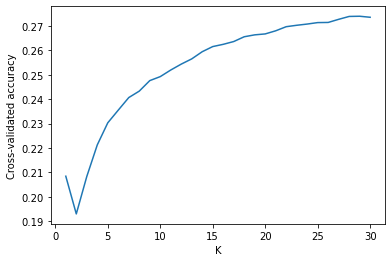

In [68]:
k_range = range(1,31)

plt.plot(k_range, k_scores)
plt.xlabel('K')
plt.ylabel('Cross-validated accuracy')

k_scores = np.asarray(k_scores)
print('The best K is', np.argmax(k_scores)+1, 'with accuracy', max(k_scores))

**Questions (2 points):** 
    
- Based on the cross-validation results above, choose the best value for k,   

- Retrain the classifier using all the training data, and test it on the test data. 

- What is the accuracy value for the test data?

According to the cross-validation results the best value for K is 29.

In [70]:
knn = KNeighborsClassifier(n_neighbors=29)

knn.fit(X, y)
y_pred = knn.predict(X_test)

# Compare actual values (y_test) with predicted values (y_pred)
retrain_knn_score = metrics.accuracy_score(y_test, y_pred)

print('Accuracy:', retrain_knn_score)

Accuracy: 0.0994


## 2- Logistic Regression (LR)


In this exercise you will implement a LR classifier.

**Question (2 points):** 

- Create and train the Logistic Regression model
- Calculate the accuracy and the confusion matrix on test dataset

In [31]:
# Create logistic regression classifier
logreg = LogisticRegression()

# Fit the model with data (training)
logreg.fit(X,y)

# Predict the response values for the observations in X
predictions = logreg.predict(X_test)

print('Accuracy:', metrics.accuracy_score(y_test, predictions))

Accuracy: 0.1008


<AxesSubplot:>

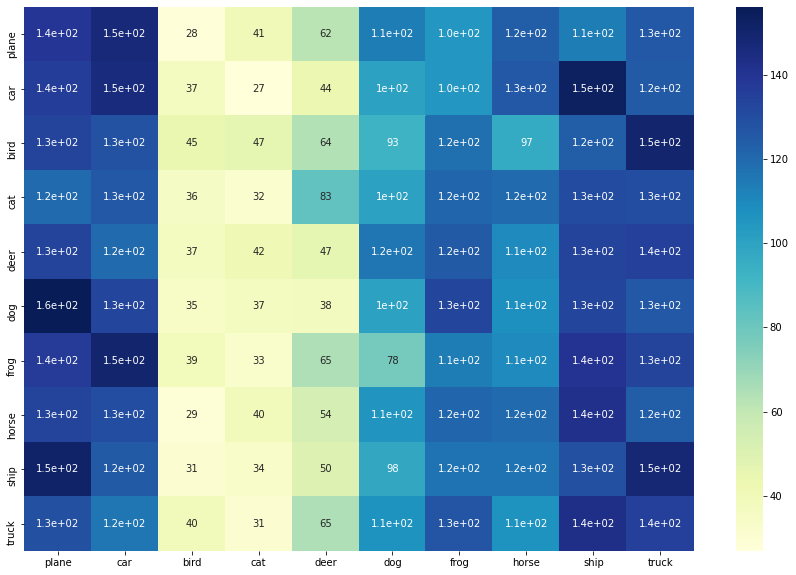

In [32]:
matrix = confusion_matrix(y_test, predictions)

df_cm = pd.DataFrame(matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (15,10))

sn.heatmap(df_cm, annot=True, cmap="YlGnBu")

## 3- Multilayer perceptron 
In this exercise you will develop a neural network with one hidden layer to perform classification.

Use:

- solver for weight optimization: stochastic gradient-based optimizer ('sgd')
- activation function for the hidden layer: rectified linear unit function ('relu')
- Early stop

**Questions (3 points):** 
- What is the prediction accuracy for the test data?
-  To evaluate the MLP model, calculate the metrics such as a confusion matrix, precision, recall, and f1 score. 
-  Show the predicted results (classification lable) on 5 random example of test dataset.
- Show 5 random of wrong predictions

In [17]:
mlp = MLPClassifier(solver="sgd", activation="relu", early_stopping=True)

mlp.fit(X, y)
predictions = mlp.predict(X_test)

In [18]:
print('The accuracy of MLP is:', metrics.accuracy_score(y_test, predictions))

The accuracy of MLP is: 0.1043


<AxesSubplot:>

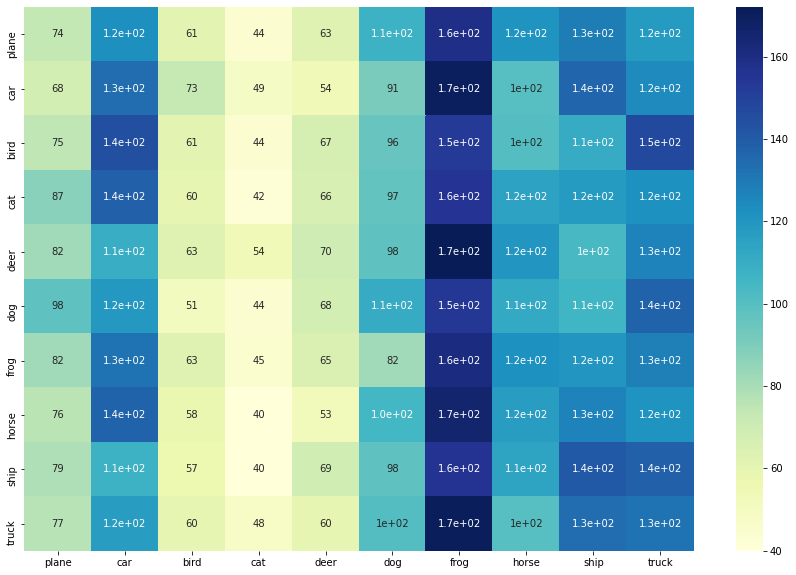

In [19]:
matrix = confusion_matrix(y_test, predictions)

df_cm = pd.DataFrame(matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (15,10))

sn.heatmap(df_cm, annot=True, cmap="YlGnBu")

In [22]:
from sklearn.metrics import classification_report
print("Classification report for MLP: \n", classification_report(y_test, predictions))

Classification report for MLP: 
               precision    recall  f1-score   support

           0       0.09      0.07      0.08      1000
           1       0.11      0.13      0.12      1000
           2       0.10      0.06      0.08      1000
           3       0.09      0.04      0.06      1000
           4       0.11      0.07      0.09      1000
           5       0.11      0.11      0.11      1000
           6       0.10      0.16      0.12      1000
           7       0.10      0.12      0.11      1000
           8       0.12      0.14      0.13      1000
           9       0.10      0.13      0.12      1000

    accuracy                           0.10     10000
   macro avg       0.10      0.10      0.10     10000
weighted avg       0.10      0.10      0.10     10000



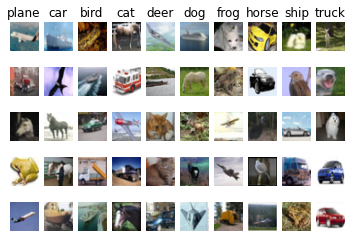

In [52]:
# Show predicted results

samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(predictions)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()